# Загрузка данных

## Иморты

In [59]:
import json
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

from wordcloud import WordCloud, STOPWORDS

<Figure size 1000x600 with 0 Axes>

## Загрузка

In [19]:
df = pd.read_json('../data/alzheimer_articles.json')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   pmid          100 non-null    int64
 1   title         100 non-null    str  
 2   abstract      100 non-null    str  
 3   year          100 non-null    int64
 4   url           100 non-null    str  
 5   introduction  100 non-null    str  
 6   conclusion    100 non-null    str  
dtypes: int64(2), str(5)
memory usage: 5.6 KB


In [8]:
df.head()

,pmid,title,abstract,year,url,introduction,conclusion
0,35558075,Microglia in the Neuroinflammatory Pathogenesi...,Alzheimer's disease (AD) is the most prevalent...,2022,https://pubmed.ncbi.nlm.nih.gov/35558075/,Alzheimer’s disease (AD) is the most common ne...,"In summary, microglia are crucial mediator and..."
1,39537608,Multi-trait association analysis reveals share...,Several cardiovascular traits and diseases co-...,2024,https://pubmed.ncbi.nlm.nih.gov/39537608/,"Alzheimer’s disease (AD), the most common caus...",We adopted a comprehensive approach to underst...
2,37349091,Systematic druggable genome-wide Mendelian ran...,BACKGROUND: Alzheimer's disease (AD) is the le...,2023,https://pubmed.ncbi.nlm.nih.gov/37349091/,Alzheimer’s disease (AD) is the most common ne...,The development of novel therapeutic agents fo...
3,39031970,The neuroinflammatory role of microglia in Alz...,"INTRODUCTION: Alzheimer's disease (AD), the ma...",2024,https://pubmed.ncbi.nlm.nih.gov/39031970/,Alzheimer's disease (AD); a toxic neurodegener...,Chronic inflammation is currently considered t...
4,40247363,TREM2 and sTREM2 in Alzheimer's disease: from ...,Triggering receptor expressed on myeloid cells...,2025,https://pubmed.ncbi.nlm.nih.gov/40247363/,Alzheimer’s disease (AD) is a devastating neur...,"TREM2, both as a cell-surface receptor and in ..."


Данные целые, пропусков нет

# Анализ данных

## Длины текстов

In [ ]:
# Статистический анализ текстовых данных
df_describe = df.copy().drop(columns=['pmid', 'year', 'title', 'abstract', 'introduction', 'conclusion'])
df_describe['title'] = df['title'].str.len()
df_describe['abstract'] = df['abstract'].str.len()
df_describe['introduction'] = df['introduction'].fillna('').str.len()
df_describe['conclusion'] = df['conclusion'].fillna('').str.len()
df_describe.describe()

,title,abstract,introduction,conclusion
count,100.000000,100.000000,100.000000,100.000000
mean,97.130000,1323.330000,3841.960000,4438.780000
std,28.766442,366.640166,1763.980885,4145.379354
min,43.000000,670.000000,1205.000000,272.000000
25%,72.750000,1090.750000,2579.750000,1511.250000
50%,96.000000,1244.500000,3545.500000,2893.000000
75%,115.250000,1498.750000,4838.500000,6109.750000
max,170.000000,2706.000000,12439.000000,18272.000000


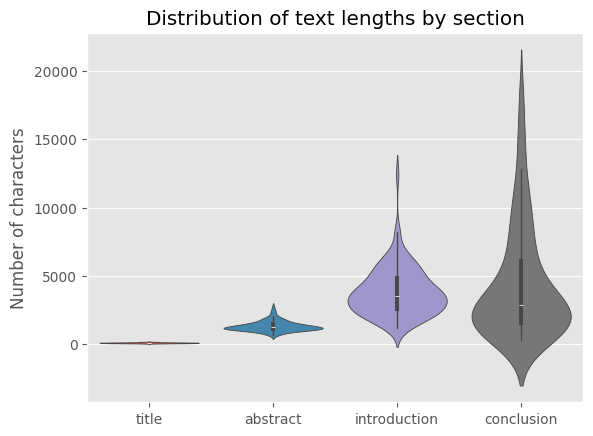

In [ ]:
sns.violinplot(data=df_describe[[
    'title',
    'abstract',
    'introduction',
    'conclusion'
    ]],
)

plt.ylabel('Number of characters')
plt.title('Distribution of text lengths by section')
plt.show()

Распределение длин текстов показало, что в данных есть выбросы в Введении и Выводах, скорее всего это обзорные статьи. 

Проверим, что длинные статьи содержательны.

In [70]:
df[df['conclusion'].str.len() > 15000]

,pmid,title,abstract,year,url,introduction,conclusion
14,40050982,Biomarker identification for Alzheimer's disea...,BACKGROUND: Alzheimer's disease (AD) is the ma...,2025,https://pubmed.ncbi.nlm.nih.gov/40050982/,Alzheimer’s disease (AD) is a progressive neur...,"In this study, our comprehensive pipeline incl..."
46,40310500,Role of Ion Channels in Alzheimer's Disease Pa...,Ion channels play an integral role in the norm...,2025,https://pubmed.ncbi.nlm.nih.gov/40310500/,Alzheimer’s disease (AD) is a progressive neur...,"In this review, we outline the roles that diff..."
49,41350740,Genetic insights into drug targets for alzheim...,BACKGROUND: The development of effective disea...,2025,https://pubmed.ncbi.nlm.nih.gov/41350740/,The increasing global burden of Alzheimer’s di...,Identifying possible mechanisms for drug targe...
96,40057579,Network pharmacology and metabolomics analysis...,Tinospora cordifolia has been used for thousan...,2025,https://pubmed.ncbi.nlm.nih.gov/40057579/,Plant omics is an emerging field in systems bi...,Neuroprotection largely refers to improving ne...


Выбросы являются информативными

## Анализ по годам

Text(0.5, 1.0, 'Number of articles by year')

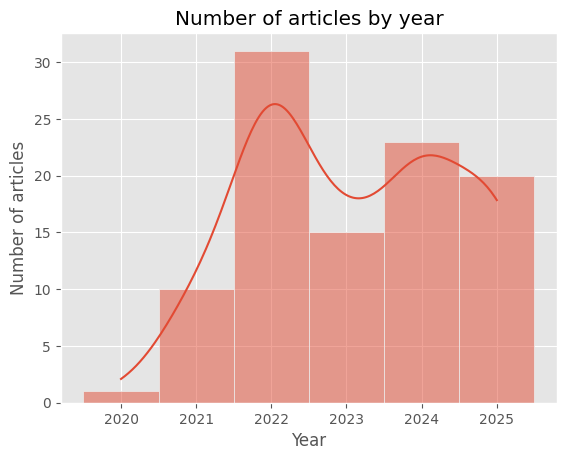

In [99]:
sns.histplot(
    data=df,
    x='year',
    kde=True,
    bins=5,
    discrete=True,
)

plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Number of articles by year')

При сборе данных использовалась сортировка по релевантным статьям. Благодаря этому были отобраны наиболее свежие статьи (за последние 5 лет).

Небольшой спад в 2023 году может быть связан как с особенностями выборки, так и с циклами научных публикаций.


## Облако ключевых слов

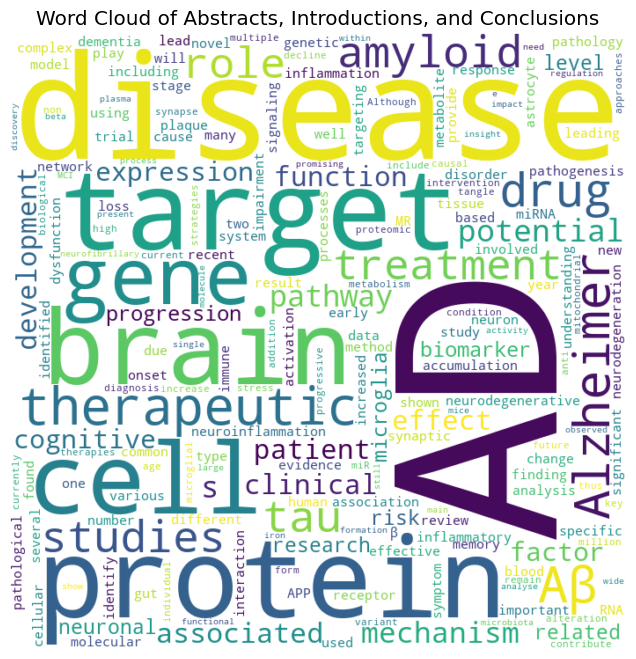

In [ ]:
# Создаем общий текст из всех абстрактов, введений и заключений
total_text = ' '.join(df['abstract'].fillna('').tolist()) +\
    ' '.join(df['introduction'].fillna('').tolist()) +\
    ' '.join(df['conclusion'].fillna('').tolist())

# Добавляем свои частые стоп-слова из статей
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["et", "al", "fig", "figure", "table", "may", "suggest"])

# Создаем и отображаем облако слов
wordcloud = WordCloud(
    width=700,
    height=700,
    background_color='white',
    stopwords=custom_stopwords,
    collocations=False
).generate(total_text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Abstracts, Introductions, and Conclusions')
plt.show()

В тексте преобладают 

# Чанкинг

## Подготовка данных для RAG